In [62]:
import pandas as pd
df = pd.read_csv("data.csv", encoding='latin1')

/tmp/ipython-input-2542465129.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding='latin1')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

ROLL_NUM = 102316039

In [64]:
X=df['no2'].dropna().values
X[:5]

array([17.4,  7. , 28.5, 14.7,  7.5])

In [65]:
X.dtype

dtype('float64')

In [66]:
X.astype(np.float32)

array([17.4,  7. , 28.5, ..., 45. , 50. , 46. ], dtype=float32)

In [67]:
a_r = 0.5*(ROLL_NUM%7)
b_r = 0.3*((ROLL_NUM%5) + 1)

print(a_r)
print(b_r)

1.0
0.8999999999999999


In [68]:
z = X + a_r*np.sin(b_r*X)
Z_tensor=torch.tensor(z,dtype=torch.float32).view(-1,1)

Z_tensor

tensor([[17.4479],
        [ 7.0168],
        [28.9945],
        ...,
        [45.3342],
        [50.8509],
        [45.4694]])

In [69]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(1,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,1),
        )

    def forward(self,x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid(),
        )

    def forward(self,x):
        return self.net(x)

In [70]:
g=Generator()
d=Discriminator()
critera=nn.BCELoss()

g_optimizer=optim.Adam(g.parameters(),lr=0.001)
d_optimizer=optim.Adam(d.parameters(),lr=0.001)

epochs=3000
batch_size=64

In [71]:
for epoch in range(epochs):
    idx=np.random.randint(0,len(Z_tensor),batch_size)
    real_samples=Z_tensor[idx]

    real_labels=torch.ones(batch_size,1)
    fake_labels=torch.zeros(batch_size,1)

    noise=torch.randn(batch_size,1)
    fake_samples=g(noise)

    d_real=d(real_samples)
    d_fake=d(fake_samples.detach())

    d_loss=critera(d_real,real_labels) + critera(d_fake,fake_labels)

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    noise=torch.randn(batch_size,1)
    fake_samples=g(noise)
    d_fake=d(fake_samples)

    g_loss=critera(d_fake,real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if epoch%500==0:
        print(f'epoch {epoch} and D loss: {d_loss.item():.2f} and G loss: {g_loss.item():.2f}')

epoch 0 and D loss: 1.19 and G loss: 0.59
epoch 500 and D loss: 1.39 and G loss: 0.69
epoch 1000 and D loss: 1.39 and G loss: 0.70
epoch 1500 and D loss: 1.39 and G loss: 0.69
epoch 2000 and D loss: 1.39 and G loss: 0.67
epoch 2500 and D loss: 1.38 and G loss: 0.74


In [72]:
noise=torch.randn(10000,1)
z_fake=g(noise).detach().numpy().flatten()

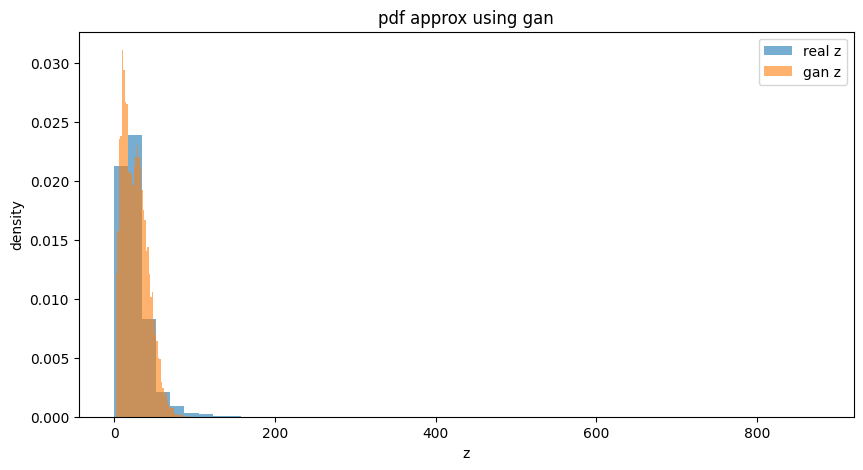

In [73]:
plt.figure(figsize=(10,5))
plt.hist(z,bins=50, density=True, alpha=0.6, label="real z")
plt.hist(z_fake,bins=50, density=True, alpha=0.6, label="gan z")

plt.xlabel('z')
plt.ylabel('density')
plt.title('pdf approx using gan')
plt.legend()
plt.show()